In [22]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
import transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

In [23]:
transformers.__version__

'3.4.0'

In [24]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [25]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [26]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [27]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [28]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [29]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5), loss=loss, metrics=['accuracy'])

    return model

In [30]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model_1 (TFXLM ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3076      
Total params: 278,046,724
Trainable params: 278,046,724
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Batch Size 32
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.28 - ETA: 5s - loss: 1.4008 - accuracy: 0.28 - ETA: 7s - loss: 1.4233 - accuracy: 0.23 - ETA: 7s - loss: 1.4223 - accuracy: 0.24 - ETA: 8s - loss: 1.4225 - accuracy: 0.23 - ETA: 8s - loss: 1.4225 - accuracy: 0.23 - ETA: 8s - loss: 1.4205 - accuracy: 0.22 - ETA: 8s - loss: 1.4171 - accuracy: 0.23 - ETA: 8s - loss: 1.4171 - accuracy: 0.23 - ETA: 8s - loss: 1.4200 - accuracy: 0.23 - ETA: 8s - loss: 1.4123 - accuracy: 0.25 - ETA: 8s - loss: 1.4110 - accuracy: 0.25 - ETA: 8s - loss: 1.4133 - accuracy: 0.25 - ETA: 8s - loss: 1.4184 - accuracy: 0.24 - ETA: 8s - loss: 1.4209 - accuracy: 0.24 - ETA: 8s - loss: 1.4192 - accuracy: 0.25 - ETA: 8s - loss: 1.4231 - accuracy: 0.24 - ETA: 7s - loss: 1.4229 - accuracy: 0.24 - ETA: 7s - loss: 1.4235 - accuracy: 0.23 - ETA: 7s - loss: 1.4233 - accuracy: 0.23 - ETA: 7s - loss: 1.4222 - accuracy: 0.23 - ETA: 8s - loss: 1.4203 - accuracy: 0.23 - ETA: 8s - loss: 1.4207 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.25 - ETA: 4s - loss: 1.3888 - accuracy: 0.28 - ETA: 6s - loss: 1.3793 - accuracy: 0.31 - ETA: 7s - loss: 1.3811 - accuracy: 0.30 - ETA: 7s - loss: 1.3874 - accuracy: 0.28 - ETA: 8s - loss: 1.3863 - accuracy: 0.27 - ETA: 8s - loss: 1.3884 - accuracy: 0.28 - ETA: 8s - loss: 1.3922 - accuracy: 0.26 - ETA: 8s - loss: 1.3896 - accuracy: 0.27 - ETA: 8s - loss: 1.3932 - accuracy: 0.26 - ETA: 8s - loss: 1.3962 - accuracy: 0.25 - ETA: 8s - loss: 1.3955 - accuracy: 0.26 - ETA: 8s - loss: 1.3975 - accuracy: 0.25 - ETA: 8s - loss: 1.3960 - accuracy: 0.26 - ETA: 8s - loss: 1.3975 - accuracy: 0.26 - ETA: 7s - loss: 1.3968 - accuracy: 0.26 - ETA: 7s - loss: 1.3956 - accuracy: 0.26 - ETA: 7s - loss: 1.3948 - accuracy: 0.26 - ETA: 7s - loss: 1.3947 - accuracy: 0.26 - ETA: 7s - loss: 1.3928 - accuracy: 0.27 - ETA: 7s - loss: 1.3907 - accuracy: 0.27 - ETA: 7s - loss: 1.3894 - accuracy: 0.27 - ETA: 7s - loss: 1.3873 

Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 1.3555 - accuracy: 0.34 - ETA: 5s - loss: 1.3787 - accuracy: 0.28 - ETA: 6s - loss: 1.3889 - accuracy: 0.26 - ETA: 7s - loss: 1.3776 - accuracy: 0.27 - ETA: 7s - loss: 1.3723 - accuracy: 0.28 - ETA: 8s - loss: 1.3655 - accuracy: 0.31 - ETA: 8s - loss: 1.3733 - accuracy: 0.30 - ETA: 8s - loss: 1.3784 - accuracy: 0.29 - ETA: 8s - loss: 1.3792 - accuracy: 0.29 - ETA: 8s - loss: 1.3803 - accuracy: 0.29 - ETA: 8s - loss: 1.3821 - accuracy: 0.28 - ETA: 8s - loss: 1.3832 - accuracy: 0.28 - ETA: 8s - loss: 1.3831 - accuracy: 0.29 - ETA: 8s - loss: 1.3803 - accuracy: 0.30 - ETA: 8s - loss: 1.3807 - accuracy: 0.30 - ETA: 8s - loss: 1.3781 - accuracy: 0.30 - ETA: 7s - loss: 1.3765 - accuracy: 0.30 - ETA: 7s - loss: 1.3765 - accuracy: 0.30 - ETA: 7s - loss: 1.3762 - accuracy: 0.30 - ETA: 7s - loss: 1.3754 - accuracy: 0.29 - ETA: 7s - loss: 1.3768 - accuracy: 0.29 - ETA: 7s - loss: 1.3755 - accuracy: 0.29 - ETA: 7s - loss: 1.3747 

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 1.2888 - accuracy: 0.46 - ETA: 4s - loss: 1.3144 - accuracy: 0.39 - ETA: 6s - loss: 1.3571 - accuracy: 0.32 - ETA: 7s - loss: 1.3384 - accuracy: 0.35 - ETA: 7s - loss: 1.3430 - accuracy: 0.35 - ETA: 7s - loss: 1.3140 - accuracy: 0.40 - ETA: 8s - loss: 1.2944 - accuracy: 0.43 - ETA: 8s - loss: 1.2919 - accuracy: 0.44 - ETA: 8s - loss: 1.2885 - accuracy: 0.44 - ETA: 8s - loss: 1.2794 - accuracy: 0.46 - ETA: 8s - loss: 1.2763 - accuracy: 0.46 - ETA: 8s - loss: 1.2787 - accuracy: 0.46 - ETA: 8s - loss: 1.2825 - accuracy: 0.45 - ETA: 8s - loss: 1.2807 - accuracy: 0.45 - ETA: 8s - loss: 1.2823 - accuracy: 0.44 - ETA: 8s - loss: 1.2839 - accuracy: 0.44 - ETA: 8s - loss: 1.2833 - accuracy: 0.44 - ETA: 7s - loss: 1.2811 - accuracy: 0.44 - ETA: 7s - loss: 1.2808 - accuracy: 0.44 - ETA: 7s - loss: 1.2769 - accuracy: 0.45 - ETA: 7s - loss: 1.2764 - accuracy: 0.45 - ETA: 7s - loss: 1.2689 - accuracy: 0.46 - ETA: 7s - loss: 1.2693 

Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 1.1243 - accuracy: 0.62 - ETA: 4s - loss: 0.9921 - accuracy: 0.73 - ETA: 6s - loss: 1.0144 - accuracy: 0.70 - ETA: 7s - loss: 1.0285 - accuracy: 0.70 - ETA: 8s - loss: 1.0254 - accuracy: 0.70 - ETA: 8s - loss: 1.0131 - accuracy: 0.71 - ETA: 8s - loss: 1.0162 - accuracy: 0.71 - ETA: 8s - loss: 1.0295 - accuracy: 0.70 - ETA: 8s - loss: 1.0319 - accuracy: 0.70 - ETA: 8s - loss: 1.0329 - accuracy: 0.70 - ETA: 8s - loss: 1.0463 - accuracy: 0.69 - ETA: 8s - loss: 1.0512 - accuracy: 0.68 - ETA: 8s - loss: 1.0441 - accuracy: 0.69 - ETA: 8s - loss: 1.0542 - accuracy: 0.68 - ETA: 8s - loss: 1.0656 - accuracy: 0.67 - ETA: 8s - loss: 1.0635 - accuracy: 0.67 - ETA: 8s - loss: 1.0527 - accuracy: 0.68 - ETA: 8s - loss: 1.0465 - accuracy: 0.69 - ETA: 8s - loss: 1.0436 - accuracy: 0.69 - ETA: 8s - loss: 1.0390 - accuracy: 0.70 - ETA: 8s - loss: 1.0398 - accuracy: 0.69 - ETA: 8s - loss: 1.0418 - accuracy: 0.69 - ETA: 7s - loss: 1.0367 

Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 0.9047 - accuracy: 0.84 - ETA: 4s - loss: 0.9048 - accuracy: 0.84 - ETA: 6s - loss: 0.8893 - accuracy: 0.85 - ETA: 7s - loss: 0.9280 - accuracy: 0.82 - ETA: 7s - loss: 0.9228 - accuracy: 0.82 - ETA: 8s - loss: 0.9340 - accuracy: 0.80 - ETA: 9s - loss: 0.9124 - accuracy: 0.83 - ETA: 9s - loss: 0.9238 - accuracy: 0.82 - ETA: 9s - loss: 0.9201 - accuracy: 0.82 - ETA: 9s - loss: 0.9310 - accuracy: 0.81 - ETA: 8s - loss: 0.9254 - accuracy: 0.81 - ETA: 8s - loss: 0.9345 - accuracy: 0.80 - ETA: 8s - loss: 0.9346 - accuracy: 0.80 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9376 - accuracy: 0.80 - ETA: 8s - loss: 0.9425 - accuracy: 0.79 - ETA: 8s - loss: 0.9409 - accuracy: 0.79 - ETA: 8s - loss: 0.9344 - accuracy: 0.80 - ETA: 8s - loss: 0.9342 - accuracy: 0.80 - ETA: 8s - loss: 0.9393 - accuracy: 0.80 - ETA: 8s - loss: 0.9346 - accuracy: 0.80 - ETA: 7s - loss: 0.9363 - accuracy: 0.80 - ETA: 7s - loss: 0.9388

Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.87 - ETA: 5s - loss: 0.9100 - accuracy: 0.84 - ETA: 6s - loss: 0.8978 - accuracy: 0.85 - ETA: 7s - loss: 0.8917 - accuracy: 0.85 - ETA: 7s - loss: 0.8928 - accuracy: 0.85 - ETA: 8s - loss: 0.8906 - accuracy: 0.85 - ETA: 8s - loss: 0.8952 - accuracy: 0.84 - ETA: 8s - loss: 0.9043 - accuracy: 0.83 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9358 - accuracy: 0.80 - ETA: 8s - loss: 0.9439 - accuracy: 0.79 - ETA: 8s - loss: 0.9445 - accuracy: 0.79 - ETA: 8s - loss: 0.9479 - accuracy: 0.78 - ETA: 8s - loss: 0.9533 - accuracy: 0.77 - ETA: 8s - loss: 0.9696 - accuracy: 0.75 - ETA: 8s - loss: 0.9807 - accuracy: 0.74 - ETA: 7s - loss: 0.9817 - accuracy: 0.74 - ETA: 7s - loss: 0.9852 - accuracy: 0.74 - ETA: 7s - loss: 0.9950 - accuracy: 0.73 - ETA: 7s - loss: 1.0017 - accuracy: 0.72 - ETA: 7s - loss: 1.0086 - accuracy: 0.71 - ETA: 7s - loss: 1.0143

Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.78 - ETA: 4s - loss: 0.9415 - accuracy: 0.78 - ETA: 6s - loss: 0.9426 - accuracy: 0.78 - ETA: 7s - loss: 0.9408 - accuracy: 0.78 - ETA: 7s - loss: 0.9413 - accuracy: 0.79 - ETA: 7s - loss: 0.9491 - accuracy: 0.78 - ETA: 8s - loss: 0.9498 - accuracy: 0.78 - ETA: 8s - loss: 0.9374 - accuracy: 0.80 - ETA: 8s - loss: 0.9299 - accuracy: 0.80 - ETA: 8s - loss: 0.9359 - accuracy: 0.80 - ETA: 8s - loss: 0.9275 - accuracy: 0.81 - ETA: 8s - loss: 0.9300 - accuracy: 0.80 - ETA: 8s - loss: 0.9208 - accuracy: 0.81 - ETA: 8s - loss: 0.9209 - accuracy: 0.81 - ETA: 8s - loss: 0.9266 - accuracy: 0.81 - ETA: 8s - loss: 0.9257 - accuracy: 0.81 - ETA: 7s - loss: 0.9225 - accuracy: 0.81 - ETA: 7s - loss: 0.9161 - accuracy: 0.82 - ETA: 7s - loss: 0.9193 - accuracy: 0.82 - ETA: 7s - loss: 0.9162 - accuracy: 0.82 - ETA: 7s - loss: 0.9223 - accuracy: 0.81 - ETA: 7s - loss: 0.9189 - accuracy: 0.82 - ETA: 7s - loss: 0.9181

Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.93 - ETA: 4s - loss: 0.8603 - accuracy: 0.87 - ETA: 6s - loss: 0.8620 - accuracy: 0.87 - ETA: 7s - loss: 0.8423 - accuracy: 0.89 - ETA: 7s - loss: 0.8540 - accuracy: 0.88 - ETA: 8s - loss: 0.8621 - accuracy: 0.87 - ETA: 8s - loss: 0.8566 - accuracy: 0.88 - ETA: 8s - loss: 0.8597 - accuracy: 0.87 - ETA: 8s - loss: 0.8715 - accuracy: 0.86 - ETA: 8s - loss: 0.8737 - accuracy: 0.86 - ETA: 8s - loss: 0.8723 - accuracy: 0.86 - ETA: 8s - loss: 0.8675 - accuracy: 0.87 - ETA: 8s - loss: 0.8640 - accuracy: 0.87 - ETA: 8s - loss: 0.8708 - accuracy: 0.87 - ETA: 8s - loss: 0.8710 - accuracy: 0.87 - ETA: 7s - loss: 0.8747 - accuracy: 0.86 - ETA: 7s - loss: 0.8770 - accuracy: 0.86 - ETA: 7s - loss: 0.8782 - accuracy: 0.86 - ETA: 7s - loss: 0.8760 - accuracy: 0.86 - ETA: 7s - loss: 0.8741 - accuracy: 0.86 - ETA: 7s - loss: 0.8758 - accuracy: 0.86 - ETA: 7s - loss: 0.8762 - accuracy: 0.86 - ETA: 7s - loss: 0.8713

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.84 - ETA: 4s - loss: 0.8579 - accuracy: 0.87 - ETA: 6s - loss: 0.8970 - accuracy: 0.84 - ETA: 7s - loss: 0.8741 - accuracy: 0.87 - ETA: 7s - loss: 0.8825 - accuracy: 0.86 - ETA: 7s - loss: 0.8793 - accuracy: 0.86 - ETA: 8s - loss: 0.8774 - accuracy: 0.86 - ETA: 8s - loss: 0.8730 - accuracy: 0.87 - ETA: 8s - loss: 0.8622 - accuracy: 0.88 - ETA: 8s - loss: 0.8635 - accuracy: 0.88 - ETA: 8s - loss: 0.8641 - accuracy: 0.88 - ETA: 8s - loss: 0.8592 - accuracy: 0.88 - ETA: 8s - loss: 0.8602 - accuracy: 0.88 - ETA: 8s - loss: 0.8522 - accuracy: 0.89 - ETA: 8s - loss: 0.8524 - accuracy: 0.89 - ETA: 8s - loss: 0.8478 - accuracy: 0.89 - ETA: 7s - loss: 0.8494 - accuracy: 0.89 - ETA: 7s - loss: 0.8496 - accuracy: 0.89 - ETA: 7s - loss: 0.8518 - accuracy: 0.89 - ETA: 7s - loss: 0.8576 - accuracy: 0.88 - ETA: 7s - loss: 0.8576 - accuracy: 0.88 - ETA: 7s - loss: 0.8585 - accuracy: 0.88 - ETA: 7s - loss: 0.8610

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.90 - ETA: 5s - loss: 0.8326 - accuracy: 0.90 - ETA: 6s - loss: 0.8792 - accuracy: 0.85 - ETA: 7s - loss: 0.8788 - accuracy: 0.85 - ETA: 7s - loss: 0.8581 - accuracy: 0.88 - ETA: 8s - loss: 0.8469 - accuracy: 0.89 - ETA: 8s - loss: 0.8462 - accuracy: 0.89 - ETA: 8s - loss: 0.8670 - accuracy: 0.87 - ETA: 8s - loss: 0.8683 - accuracy: 0.87 - ETA: 8s - loss: 0.8681 - accuracy: 0.87 - ETA: 8s - loss: 0.8689 - accuracy: 0.86 - ETA: 8s - loss: 0.8621 - accuracy: 0.87 - ETA: 8s - loss: 0.8603 - accuracy: 0.87 - ETA: 8s - loss: 0.8559 - accuracy: 0.88 - ETA: 8s - loss: 0.8506 - accuracy: 0.88 - ETA: 8s - loss: 0.8479 - accuracy: 0.89 - ETA: 8s - loss: 0.8449 - accuracy: 0.89 - ETA: 7s - loss: 0.8416 - accuracy: 0.89 - ETA: 7s - loss: 0.8441 - accuracy: 0.89 - ETA: 7s - loss: 0.8452 - accuracy: 0.89 - ETA: 7s - loss: 0.8444 - accuracy: 0.89 - ETA: 7s - loss: 0.8453 - accuracy: 0.89 - ETA: 7s - loss: 0.8489

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.87 - ETA: 4s - loss: 0.8732 - accuracy: 0.87 - ETA: 6s - loss: 0.8686 - accuracy: 0.87 - ETA: 7s - loss: 0.8452 - accuracy: 0.89 - ETA: 7s - loss: 0.8380 - accuracy: 0.90 - ETA: 7s - loss: 0.8290 - accuracy: 0.91 - ETA: 8s - loss: 0.8213 - accuracy: 0.92 - ETA: 9s - loss: 0.8165 - accuracy: 0.92 - ETA: 9s - loss: 0.8136 - accuracy: 0.93 - ETA: 9s - loss: 0.8161 - accuracy: 0.93 - ETA: 8s - loss: 0.8179 - accuracy: 0.92 - ETA: 8s - loss: 0.8210 - accuracy: 0.92 - ETA: 8s - loss: 0.8247 - accuracy: 0.92 - ETA: 8s - loss: 0.8233 - accuracy: 0.92 - ETA: 8s - loss: 0.8246 - accuracy: 0.92 - ETA: 8s - loss: 0.8231 - accuracy: 0.92 - ETA: 8s - loss: 0.8221 - accuracy: 0.92 - ETA: 8s - loss: 0.8250 - accuracy: 0.92 - ETA: 8s - loss: 0.8227 - accuracy: 0.92 - ETA: 8s - loss: 0.8218 - accuracy: 0.92 - ETA: 7s - loss: 0.8226 - accuracy: 0.92 - ETA: 7s - loss: 0.8247 - accuracy: 0.92 - ETA: 7s - loss: 0.8284

Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.93 - ETA: 4s - loss: 0.8331 - accuracy: 0.92 - ETA: 6s - loss: 0.8358 - accuracy: 0.91 - ETA: 7s - loss: 0.8304 - accuracy: 0.92 - ETA: 7s - loss: 0.8331 - accuracy: 0.91 - ETA: 7s - loss: 0.8445 - accuracy: 0.90 - ETA: 8s - loss: 0.8367 - accuracy: 0.91 - ETA: 8s - loss: 0.8406 - accuracy: 0.91 - ETA: 8s - loss: 0.8487 - accuracy: 0.90 - ETA: 8s - loss: 0.8384 - accuracy: 0.91 - ETA: 8s - loss: 0.8344 - accuracy: 0.91 - ETA: 8s - loss: 0.8287 - accuracy: 0.91 - ETA: 8s - loss: 0.8278 - accuracy: 0.92 - ETA: 8s - loss: 0.8219 - accuracy: 0.92 - ETA: 8s - loss: 0.8208 - accuracy: 0.92 - ETA: 7s - loss: 0.8255 - accuracy: 0.92 - ETA: 7s - loss: 0.8262 - accuracy: 0.92 - ETA: 7s - loss: 0.8239 - accuracy: 0.92 - ETA: 7s - loss: 0.8227 - accuracy: 0.92 - ETA: 7s - loss: 0.8221 - accuracy: 0.92 - ETA: 7s - loss: 0.8223 - accuracy: 0.92 - ETA: 7s - loss: 0.8247 - accuracy: 0.92 - ETA: 7s - loss: 0.8266

Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.84 - ETA: 5s - loss: 0.8881 - accuracy: 0.85 - ETA: 6s - loss: 0.8420 - accuracy: 0.90 - ETA: 7s - loss: 0.8255 - accuracy: 0.92 - ETA: 7s - loss: 0.8222 - accuracy: 0.92 - ETA: 8s - loss: 0.8216 - accuracy: 0.92 - ETA: 8s - loss: 0.8156 - accuracy: 0.93 - ETA: 8s - loss: 0.8194 - accuracy: 0.92 - ETA: 8s - loss: 0.8151 - accuracy: 0.93 - ETA: 8s - loss: 0.8080 - accuracy: 0.93 - ETA: 8s - loss: 0.8105 - accuracy: 0.93 - ETA: 8s - loss: 0.8071 - accuracy: 0.93 - ETA: 8s - loss: 0.8127 - accuracy: 0.93 - ETA: 8s - loss: 0.8125 - accuracy: 0.93 - ETA: 8s - loss: 0.8111 - accuracy: 0.93 - ETA: 8s - loss: 0.8158 - accuracy: 0.92 - ETA: 8s - loss: 0.8145 - accuracy: 0.92 - ETA: 7s - loss: 0.8147 - accuracy: 0.92 - ETA: 7s - loss: 0.8131 - accuracy: 0.92 - ETA: 7s - loss: 0.8121 - accuracy: 0.92 - ETA: 7s - loss: 0.8123 - accuracy: 0.93 - ETA: 7s - loss: 0.8120 - accuracy: 0.93 - ETA: 7s - loss: 0.8125

Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.93 - ETA: 4s - loss: 0.7914 - accuracy: 0.95 - ETA: 6s - loss: 0.8065 - accuracy: 0.93 - ETA: 7s - loss: 0.8063 - accuracy: 0.93 - ETA: 7s - loss: 0.8066 - accuracy: 0.93 - ETA: 8s - loss: 0.8169 - accuracy: 0.92 - ETA: 8s - loss: 0.8236 - accuracy: 0.91 - ETA: 8s - loss: 0.8156 - accuracy: 0.92 - ETA: 8s - loss: 0.8213 - accuracy: 0.92 - ETA: 8s - loss: 0.8140 - accuracy: 0.93 - ETA: 8s - loss: 0.8133 - accuracy: 0.93 - ETA: 8s - loss: 0.8124 - accuracy: 0.93 - ETA: 8s - loss: 0.8117 - accuracy: 0.93 - ETA: 8s - loss: 0.8113 - accuracy: 0.93 - ETA: 8s - loss: 0.8072 - accuracy: 0.93 - ETA: 8s - loss: 0.8071 - accuracy: 0.93 - ETA: 7s - loss: 0.8099 - accuracy: 0.93 - ETA: 7s - loss: 0.8115 - accuracy: 0.93 - ETA: 7s - loss: 0.8096 - accuracy: 0.93 - ETA: 7s - loss: 0.8141 - accuracy: 0.92 - ETA: 7s - loss: 0.8112 - accuracy: 0.93 - ETA: 7s - loss: 0.8123 - accuracy: 0.93 - ETA: 7s - loss: 0.8149

Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 1.00 - ETA: 4s - loss: 0.7597 - accuracy: 0.98 - ETA: 6s - loss: 0.7648 - accuracy: 0.97 - ETA: 7s - loss: 0.7595 - accuracy: 0.98 - ETA: 7s - loss: 0.7626 - accuracy: 0.98 - ETA: 8s - loss: 0.7699 - accuracy: 0.97 - ETA: 8s - loss: 0.7694 - accuracy: 0.97 - ETA: 8s - loss: 0.7855 - accuracy: 0.95 - ETA: 8s - loss: 0.7844 - accuracy: 0.95 - ETA: 8s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7981 - accuracy: 0.94 - ETA: 8s - loss: 0.8025 - accuracy: 0.93 - ETA: 8s - loss: 0.8083 - accuracy: 0.93 - ETA: 8s - loss: 0.8067 - accuracy: 0.93 - ETA: 8s - loss: 0.8058 - accuracy: 0.93 - ETA: 8s - loss: 0.8048 - accuracy: 0.93 - ETA: 7s - loss: 0.8032 - accuracy: 0.93 - ETA: 7s - loss: 0.8025 - accuracy: 0.93 - ETA: 7s - loss: 0.8030 - accuracy: 0.93 - ETA: 7s - loss: 0.8003 - accuracy: 0.94 - ETA: 7s - loss: 0.8006 - accuracy: 0.94 - ETA: 7s - loss: 0.8011

Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.93 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 6s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7770 - accuracy: 0.96 - ETA: 7s - loss: 0.7979 - accuracy: 0.94 - ETA: 8s - loss: 0.7946 - accuracy: 0.95 - ETA: 8s - loss: 0.7926 - accuracy: 0.95 - ETA: 8s - loss: 0.7976 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7925 - accuracy: 0.95 - ETA: 8s - loss: 0.7964 - accuracy: 0.94 - ETA: 8s - loss: 0.8002 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7979 - accuracy: 0.94 - ETA: 8s - loss: 0.7985 - accuracy: 0.94 - ETA: 7s - loss: 0.7998 - accuracy: 0.94 - ETA: 7s - loss: 0.8001 - accuracy: 0.94 - ETA: 8s - loss: 0.7994 - accuracy: 0.94 - ETA: 8s - loss: 0.8027 - accuracy: 0.94 - ETA: 8s - loss: 0.8043 - accuracy: 0.93 - ETA: 7s - loss: 0.8076 - accuracy: 0.93 - ETA: 7s - loss: 0.8076

Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.93 - ETA: 5s - loss: 0.8086 - accuracy: 0.93 - ETA: 6s - loss: 0.8182 - accuracy: 0.92 - ETA: 7s - loss: 0.8305 - accuracy: 0.91 - ETA: 7s - loss: 0.8132 - accuracy: 0.93 - ETA: 7s - loss: 0.8016 - accuracy: 0.94 - ETA: 8s - loss: 0.7933 - accuracy: 0.95 - ETA: 8s - loss: 0.7988 - accuracy: 0.94 - ETA: 8s - loss: 0.7973 - accuracy: 0.94 - ETA: 8s - loss: 0.7984 - accuracy: 0.94 - ETA: 8s - loss: 0.8048 - accuracy: 0.94 - ETA: 9s - loss: 0.8023 - accuracy: 0.94 - ETA: 9s - loss: 0.8026 - accuracy: 0.94 - ETA: 9s - loss: 0.8028 - accuracy: 0.94 - ETA: 8s - loss: 0.8014 - accuracy: 0.94 - ETA: 8s - loss: 0.7997 - accuracy: 0.94 - ETA: 8s - loss: 0.8009 - accuracy: 0.94 - ETA: 8s - loss: 0.7996 - accuracy: 0.94 - ETA: 8s - loss: 0.7967 - accuracy: 0.94 - ETA: 8s - loss: 0.7941 - accuracy: 0.95 - ETA: 8s - loss: 0.7932 - accuracy: 0.95 - ETA: 8s - loss: 0.7924 - accuracy: 0.95 - ETA: 7s - loss: 0.7930

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.8160 - accuracy: 0.92 - ETA: 10s - loss: 0.7923 - accuracy: 0.947 - ETA: 11s - loss: 0.7840 - accuracy: 0.953 - ETA: 10s - loss: 0.7769 - accuracy: 0.962 - ETA: 10s - loss: 0.7817 - accuracy: 0.958 - ETA: 10s - loss: 0.7909 - accuracy: 0.950 - ETA: 10s - loss: 0.7900 - accuracy: 0.953 - ETA: 9s - loss: 0.7884 - accuracy: 0.954 - ETA: 9s - loss: 0.7904 - accuracy: 0.95 - ETA: 9s - loss: 0.7947 - accuracy: 0.94 - ETA: 9s - loss: 0.7982 - accuracy: 0.94 - ETA: 9s - loss: 0.7988 - accuracy: 0.94 - ETA: 9s - loss: 0.7954 - accuracy: 0.94 - ETA: 8s - loss: 0.7940 - accuracy: 0.95 - ETA: 8s - loss: 0.7948 - accuracy: 0.94 - ETA: 8s - loss: 0.7971 - accuracy: 0.94 - ETA: 8s - loss: 0.7948 - accuracy: 0.94 - ETA: 8s - loss: 0.7943 - accuracy: 0.95 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7978 - accuracy: 0.94 - ETA: 8s - loss: 0.7983 - accuracy: 0.94 - ETA: 7s -

Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.90 - ETA: 4s - loss: 0.8689 - accuracy: 0.87 - ETA: 6s - loss: 0.8280 - accuracy: 0.91 - ETA: 7s - loss: 0.8147 - accuracy: 0.92 - ETA: 7s - loss: 0.8070 - accuracy: 0.93 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8020 - accuracy: 0.94 - ETA: 8s - loss: 0.7985 - accuracy: 0.94 - ETA: 8s - loss: 0.7976 - accuracy: 0.94 - ETA: 8s - loss: 0.7923 - accuracy: 0.95 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 8s - loss: 0.7919 - accuracy: 0.95 - ETA: 8s - loss: 0.7956 - accuracy: 0.94 - ETA: 8s - loss: 0.7986 - accuracy: 0.94 - ETA: 8s - loss: 0.8040 - accuracy: 0.93 - ETA: 8s - loss: 0.8022 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7976 - accuracy: 0.94 - ETA: 7s - loss: 0.7978 - accuracy: 0.94 - ETA: 7s - loss: 0.8012 - accuracy: 0.94 - ETA: 7s - loss: 0.7985 - accuracy: 0.94 - ETA: 7s - loss: 0.7975 - accuracy: 0.94 - ETA: 7s - loss: 0.7951

Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.93 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 6s - loss: 0.7651 - accuracy: 0.97 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7939 - accuracy: 0.95 - ETA: 7s - loss: 0.7903 - accuracy: 0.95 - ETA: 7s - loss: 0.7894 - accuracy: 0.95 - ETA: 8s - loss: 0.7840 - accuracy: 0.96 - ETA: 8s - loss: 0.7835 - accuracy: 0.96 - ETA: 8s - loss: 0.7829 - accuracy: 0.96 - ETA: 8s - loss: 0.7820 - accuracy: 0.96 - ETA: 8s - loss: 0.7833 - accuracy: 0.96 - ETA: 8s - loss: 0.7899 - accuracy: 0.95 - ETA: 7s - loss: 0.7866 - accuracy: 0.95 - ETA: 7s - loss: 0.7838 - accuracy: 0.96 - ETA: 7s - loss: 0.7872 - accuracy: 0.95 - ETA: 7s - loss: 0.7901 - accuracy: 0.95 - ETA: 7s - loss: 0.7927 - accuracy: 0.95 - ETA: 7s - loss: 0.7918 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7902 - accuracy: 0.95 - ETA: 7s - loss: 0.7895 - accuracy: 0.95 - ETA: 7s - loss: 0.7903

Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.93 - ETA: 4s - loss: 0.7995 - accuracy: 0.95 - ETA: 6s - loss: 0.8015 - accuracy: 0.94 - ETA: 7s - loss: 0.8035 - accuracy: 0.94 - ETA: 7s - loss: 0.7977 - accuracy: 0.95 - ETA: 8s - loss: 0.7939 - accuracy: 0.95 - ETA: 8s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7942 - accuracy: 0.95 - ETA: 8s - loss: 0.7956 - accuracy: 0.95 - ETA: 8s - loss: 0.7961 - accuracy: 0.94 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7937 - accuracy: 0.95 - ETA: 8s - loss: 0.7965 - accuracy: 0.94 - ETA: 8s - loss: 0.7971 - accuracy: 0.94 - ETA: 8s - loss: 0.7977 - accuracy: 0.94 - ETA: 8s - loss: 0.7958 - accuracy: 0.94 - ETA: 8s - loss: 0.7946 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7959 - accuracy: 0.94 - ETA: 7s - loss: 0.7995 - accuracy: 0.94 - ETA: 7s - loss: 0.7984 - accuracy: 0.94 - ETA: 7s - loss: 0.7987 - accuracy: 0.94 - ETA: 7s - loss: 0.7977

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.96 - ETA: 5s - loss: 0.7754 - accuracy: 0.96 - ETA: 6s - loss: 0.7730 - accuracy: 0.96 - ETA: 7s - loss: 0.7736 - accuracy: 0.96 - ETA: 7s - loss: 0.7930 - accuracy: 0.95 - ETA: 8s - loss: 0.7848 - accuracy: 0.95 - ETA: 8s - loss: 0.7835 - accuracy: 0.95 - ETA: 8s - loss: 0.7863 - accuracy: 0.95 - ETA: 8s - loss: 0.7850 - accuracy: 0.95 - ETA: 8s - loss: 0.7809 - accuracy: 0.96 - ETA: 8s - loss: 0.7776 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7820 - accuracy: 0.96 - ETA: 8s - loss: 0.7833 - accuracy: 0.95 - ETA: 8s - loss: 0.7807 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 7s - loss: 0.7783 - accuracy: 0.96 - ETA: 7s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7773 - accuracy: 0.96 - ETA: 7s - loss: 0.7772 - accuracy: 0.96 - ETA: 7s - loss: 0.7771 - accuracy: 0.96 - ETA: 7s - loss: 0.7755 - accuracy: 0.96 - ETA: 7s - loss: 0.7768

Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7677 - accuracy: 0.97 - ETA: 7s - loss: 0.7680 - accuracy: 0.97 - ETA: 8s - loss: 0.7693 - accuracy: 0.97 - ETA: 8s - loss: 0.7701 - accuracy: 0.97 - ETA: 8s - loss: 0.7704 - accuracy: 0.97 - ETA: 8s - loss: 0.7748 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7812 - accuracy: 0.96 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7823 - accuracy: 0.96 - ETA: 7s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7832 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7796 - accuracy: 0.96 - ETA: 7s - loss: 0.7807

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.90 - ETA: 5s - loss: 0.8135 - accuracy: 0.92 - ETA: 6s - loss: 0.8172 - accuracy: 0.91 - ETA: 7s - loss: 0.8067 - accuracy: 0.92 - ETA: 7s - loss: 0.7941 - accuracy: 0.94 - ETA: 7s - loss: 0.7964 - accuracy: 0.94 - ETA: 8s - loss: 0.7889 - accuracy: 0.95 - ETA: 8s - loss: 0.7843 - accuracy: 0.95 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 8s - loss: 0.7793 - accuracy: 0.96 - ETA: 8s - loss: 0.7765 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7763 - accuracy: 0.96 - ETA: 8s - loss: 0.7742 - accuracy: 0.96 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7787 - accuracy: 0.96 - ETA: 7s - loss: 0.7804 - accuracy: 0.96 - ETA: 7s - loss: 0.7802 - accuracy: 0.96 - ETA: 7s - loss: 0.7823 - accuracy: 0.95 - ETA: 7s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7791

Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.96 - ETA: 4s - loss: 0.7781 - accuracy: 0.96 - ETA: 6s - loss: 0.7797 - accuracy: 0.96 - ETA: 7s - loss: 0.7884 - accuracy: 0.96 - ETA: 7s - loss: 0.7794 - accuracy: 0.96 - ETA: 7s - loss: 0.7739 - accuracy: 0.97 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7801 - accuracy: 0.96 - ETA: 8s - loss: 0.7830 - accuracy: 0.96 - ETA: 8s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7788 - accuracy: 0.96 - ETA: 8s - loss: 0.7758 - accuracy: 0.96 - ETA: 8s - loss: 0.7766 - accuracy: 0.96 - ETA: 8s - loss: 0.7766 - accuracy: 0.96 - ETA: 7s - loss: 0.7787 - accuracy: 0.96 - ETA: 7s - loss: 0.7828 - accuracy: 0.96 - ETA: 7s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7841 - accuracy: 0.96 - ETA: 7s - loss: 0.7848 - accuracy: 0.95 - ETA: 7s - loss: 0.7881 - accuracy: 0.95 - ETA: 7s - loss: 0.7861 - accuracy: 0.95 - ETA: 7s - loss: 0.7857 - accuracy: 0.95 - ETA: 7s - loss: 0.7854

Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.96 - ETA: 5s - loss: 0.7537 - accuracy: 0.98 - ETA: 6s - loss: 0.7708 - accuracy: 0.96 - ETA: 7s - loss: 0.7642 - accuracy: 0.97 - ETA: 7s - loss: 0.7913 - accuracy: 0.95 - ETA: 7s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7822 - accuracy: 0.95 - ETA: 8s - loss: 0.7846 - accuracy: 0.95 - ETA: 8s - loss: 0.7836 - accuracy: 0.95 - ETA: 8s - loss: 0.7828 - accuracy: 0.95 - ETA: 8s - loss: 0.7846 - accuracy: 0.95 - ETA: 8s - loss: 0.7838 - accuracy: 0.95 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 8s - loss: 0.7782 - accuracy: 0.96 - ETA: 8s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7826 - accuracy: 0.95 - ETA: 7s - loss: 0.7821 - accuracy: 0.95 - ETA: 7s - loss: 0.7884 - accuracy: 0.95 - ETA: 7s - loss: 0.7877 - accuracy: 0.95 - ETA: 7s - loss: 0.7855 - accuracy: 0.95 - ETA: 7s - loss: 0.7866 - accuracy: 0.95 - ETA: 7s - loss: 0.7884 - accuracy: 0.95 - ETA: 7s - loss: 0.7879

Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.8215 - accuracy: 0.92 - ETA: 6s - loss: 0.7959 - accuracy: 0.94 - ETA: 7s - loss: 0.8102 - accuracy: 0.92 - ETA: 7s - loss: 0.8156 - accuracy: 0.92 - ETA: 8s - loss: 0.8088 - accuracy: 0.93 - ETA: 8s - loss: 0.7995 - accuracy: 0.94 - ETA: 8s - loss: 0.7925 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7921 - accuracy: 0.95 - ETA: 8s - loss: 0.7918 - accuracy: 0.94 - ETA: 8s - loss: 0.7956 - accuracy: 0.94 - ETA: 8s - loss: 0.7950 - accuracy: 0.94 - ETA: 8s - loss: 0.7957 - accuracy: 0.94 - ETA: 8s - loss: 0.7938 - accuracy: 0.94 - ETA: 8s - loss: 0.7930 - accuracy: 0.94 - ETA: 8s - loss: 0.7920 - accuracy: 0.95 - ETA: 7s - loss: 0.7893 - accuracy: 0.95 - ETA: 7s - loss: 0.7918 - accuracy: 0.95 - ETA: 7s - loss: 0.7924 - accuracy: 0.95 - ETA: 7s - loss: 0.7930 - accuracy: 0.94 - ETA: 7s - loss: 0.7965 - accuracy: 0.94 - ETA: 7s - loss: 0.7956

Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7762 - accuracy: 0.96 - ETA: 6s - loss: 0.7653 - accuracy: 0.97 - ETA: 7s - loss: 0.7762 - accuracy: 0.96 - ETA: 7s - loss: 0.7697 - accuracy: 0.97 - ETA: 8s - loss: 0.7706 - accuracy: 0.97 - ETA: 8s - loss: 0.7712 - accuracy: 0.97 - ETA: 8s - loss: 0.7756 - accuracy: 0.96 - ETA: 8s - loss: 0.7739 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7742 - accuracy: 0.96 - ETA: 9s - loss: 0.7719 - accuracy: 0.97 - ETA: 8s - loss: 0.7698 - accuracy: 0.97 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7705 - accuracy: 0.97 - ETA: 8s - loss: 0.7689 - accuracy: 0.97 - ETA: 8s - loss: 0.7675 - accuracy: 0.97 - ETA: 8s - loss: 0.7695 - accuracy: 0.97 - ETA: 8s - loss: 0.7713 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7731 - accuracy: 0.97 - ETA: 7s - loss: 0.7732

Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.93 - ETA: 4s - loss: 0.7761 - accuracy: 0.96 - ETA: 6s - loss: 0.7964 - accuracy: 0.94 - ETA: 7s - loss: 0.7912 - accuracy: 0.95 - ETA: 9s - loss: 0.7817 - accuracy: 0.96 - ETA: 9s - loss: 0.7806 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7815 - accuracy: 0.96 - ETA: 9s - loss: 0.7809 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7755 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7755 - accuracy: 0.96 - ETA: 8s - loss: 0.7736 - accuracy: 0.97 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 7s - loss: 0.7724 - accuracy: 0.97 - ETA: 7s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7753

Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 7s - loss: 0.7857 - accuracy: 0.96 - ETA: 7s - loss: 0.7837 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7762 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 8s - loss: 0.7734 - accuracy: 0.97 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 8s - loss: 0.7736 - accuracy: 0.97 - ETA: 8s - loss: 0.7762 - accuracy: 0.96 - ETA: 8s - loss: 0.7781 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 8s - loss: 0.7760 - accuracy: 0.96 - ETA: 8s - loss: 0.7806 - accuracy: 0.96 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7793 - accuracy: 0.96 - ETA: 7s - loss: 0.7791

Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7462 - accuracy: 1.00 - ETA: 6s - loss: 0.7566 - accuracy: 0.98 - ETA: 7s - loss: 0.7612 - accuracy: 0.98 - ETA: 7s - loss: 0.7697 - accuracy: 0.97 - ETA: 8s - loss: 0.7653 - accuracy: 0.97 - ETA: 8s - loss: 0.7622 - accuracy: 0.98 - ETA: 8s - loss: 0.7677 - accuracy: 0.97 - ETA: 8s - loss: 0.7685 - accuracy: 0.97 - ETA: 8s - loss: 0.7692 - accuracy: 0.97 - ETA: 8s - loss: 0.7669 - accuracy: 0.97 - ETA: 8s - loss: 0.7649 - accuracy: 0.97 - ETA: 8s - loss: 0.7633 - accuracy: 0.98 - ETA: 8s - loss: 0.7641 - accuracy: 0.97 - ETA: 8s - loss: 0.7690 - accuracy: 0.97 - ETA: 8s - loss: 0.7693 - accuracy: 0.97 - ETA: 7s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7734 - accuracy: 0.97 - ETA: 7s - loss: 0.7735 - accuracy: 0.97 - ETA: 7s - loss: 0.7751 - accuracy: 0.96 - ETA: 7s - loss: 0.7744 - accuracy: 0.96 - ETA: 7s - loss: 0.7758 - accuracy: 0.96 - ETA: 7s - loss: 0.7749

Epoch 65/100
94/94 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 6s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7785 - accuracy: 0.96 - ETA: 7s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7721 - accuracy: 0.97 - ETA: 8s - loss: 0.7717 - accuracy: 0.97 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7700 - accuracy: 0.97 - ETA: 8s - loss: 0.7704 - accuracy: 0.97 - ETA: 8s - loss: 0.7708 - accuracy: 0.97 - ETA: 8s - loss: 0.7685 - accuracy: 0.97 - ETA: 8s - loss: 0.7714 - accuracy: 0.97 - ETA: 7s - loss: 0.7717 - accuracy: 0.97 - ETA: 7s - loss: 0.7719 - accuracy: 0.97 - ETA: 7s - loss: 0.7740 - accuracy: 0.97 - ETA: 7s - loss: 0.7722 - accuracy: 0.97 - ETA: 7s - loss: 0.7759 - accuracy: 0.96 - ETA: 7s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7758 - accuracy: 0.96 - ETA: 7s - loss: 0.7757 - accuracy: 0.96 - ETA: 7s - loss: 0.7743 - accuracy: 0.97 - ETA: 7s - loss: 0.7729

Epoch 67/100
94/94 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.96 - ETA: 4s - loss: 0.7741 - accuracy: 0.96 - ETA: 6s - loss: 0.7640 - accuracy: 0.97 - ETA: 7s - loss: 0.7667 - accuracy: 0.97 - ETA: 7s - loss: 0.7684 - accuracy: 0.97 - ETA: 8s - loss: 0.7799 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7838 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7824 - accuracy: 0.96 - ETA: 8s - loss: 0.7797 - accuracy: 0.96 - ETA: 8s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7810 - accuracy: 0.96 - ETA: 8s - loss: 0.7807 - accuracy: 0.96 - ETA: 7s - loss: 0.7821 - accuracy: 0.96 - ETA: 7s - loss: 0.7817 - accuracy: 0.96 - ETA: 7s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7810 - accuracy: 0.96 - ETA: 7s - loss: 0.7793 - accuracy: 0.96 - ETA: 7s - loss: 0.7786

Epoch 69/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7872 - accuracy: 0.95 - ETA: 6s - loss: 0.7727 - accuracy: 0.96 - ETA: 7s - loss: 0.7732 - accuracy: 0.96 - ETA: 7s - loss: 0.7736 - accuracy: 0.96 - ETA: 7s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7738 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7792 - accuracy: 0.96 - ETA: 8s - loss: 0.7801 - accuracy: 0.96 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7771 - accuracy: 0.96 - ETA: 7s - loss: 0.7809 - accuracy: 0.96 - ETA: 7s - loss: 0.7806 - accuracy: 0.96 - ETA: 7s - loss: 0.7786 - accuracy: 0.96 - ETA: 7s - loss: 0.7784 - accuracy: 0.96 - ETA: 7s - loss: 0.7768 - accuracy: 0.96 - ETA: 7s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7767

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 1.00 - ETA: 4s - loss: 0.7488 - accuracy: 1.00 - ETA: 6s - loss: 0.7680 - accuracy: 0.97 - ETA: 7s - loss: 0.7777 - accuracy: 0.96 - ETA: 7s - loss: 0.7709 - accuracy: 0.97 - ETA: 7s - loss: 0.7768 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7739 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 8s - loss: 0.7691 - accuracy: 0.97 - ETA: 8s - loss: 0.7747 - accuracy: 0.97 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 8s - loss: 0.7718 - accuracy: 0.97 - ETA: 7s - loss: 0.7701 - accuracy: 0.97 - ETA: 7s - loss: 0.7703 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7742 - accuracy: 0.97 - ETA: 7s - loss: 0.7727 - accuracy: 0.97 - ETA: 7s - loss: 0.7728 - accuracy: 0.97 - ETA: 7s - loss: 0.7716

Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7598 - accuracy: 0.98 - ETA: 6s - loss: 0.7617 - accuracy: 0.97 - ETA: 7s - loss: 0.7649 - accuracy: 0.97 - ETA: 7s - loss: 0.7607 - accuracy: 0.98 - ETA: 7s - loss: 0.7631 - accuracy: 0.97 - ETA: 8s - loss: 0.7648 - accuracy: 0.97 - ETA: 8s - loss: 0.7621 - accuracy: 0.98 - ETA: 8s - loss: 0.7612 - accuracy: 0.98 - ETA: 8s - loss: 0.7720 - accuracy: 0.97 - ETA: 8s - loss: 0.7694 - accuracy: 0.97 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7728 - accuracy: 0.97 - ETA: 7s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7733 - accuracy: 0.97 - ETA: 7s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7735 - accuracy: 0.97 - ETA: 7s - loss: 0.7718 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7724 - accuracy: 0.97 - ETA: 7s - loss: 0.7710 - accuracy: 0.97 - ETA: 7s - loss: 0.7712 - accuracy: 0.97 - ETA: 7s - loss: 0.7754

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.93 - ETA: 4s - loss: 0.7759 - accuracy: 0.96 - ETA: 6s - loss: 0.7652 - accuracy: 0.97 - ETA: 7s - loss: 0.7676 - accuracy: 0.97 - ETA: 7s - loss: 0.7690 - accuracy: 0.97 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7794 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7759 - accuracy: 0.96 - ETA: 8s - loss: 0.7758 - accuracy: 0.96 - ETA: 8s - loss: 0.7782 - accuracy: 0.96 - ETA: 8s - loss: 0.7851 - accuracy: 0.95 - ETA: 8s - loss: 0.7910 - accuracy: 0.95 - ETA: 8s - loss: 0.7899 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7882 - accuracy: 0.95 - ETA: 7s - loss: 0.7874 - accuracy: 0.95 - ETA: 7s - loss: 0.7900 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7890 - accuracy: 0.95 - ETA: 7s - loss: 0.7871

Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.8071 - accuracy: 0.93 - ETA: 6s - loss: 0.7964 - accuracy: 0.94 - ETA: 7s - loss: 0.7832 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7896 - accuracy: 0.95 - ETA: 8s - loss: 0.7850 - accuracy: 0.96 - ETA: 8s - loss: 0.7839 - accuracy: 0.96 - ETA: 8s - loss: 0.7830 - accuracy: 0.96 - ETA: 8s - loss: 0.7794 - accuracy: 0.96 - ETA: 8s - loss: 0.7843 - accuracy: 0.96 - ETA: 8s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7809 - accuracy: 0.96 - ETA: 7s - loss: 0.7846 - accuracy: 0.96 - ETA: 7s - loss: 0.7820 - accuracy: 0.96 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7830 - accuracy: 0.96 - ETA: 7s - loss: 0.7842 - accuracy: 0.96 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7848 - accuracy: 0.95 - ETA: 7s - loss: 0.7858 - accuracy: 0.95 - ETA: 7s - loss: 0.7853

Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 5s - loss: 0.7905 - accuracy: 0.95 - ETA: 6s - loss: 0.7958 - accuracy: 0.94 - ETA: 7s - loss: 0.7829 - accuracy: 0.96 - ETA: 7s - loss: 0.7936 - accuracy: 0.95 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 8s - loss: 0.7973 - accuracy: 0.94 - ETA: 8s - loss: 0.8023 - accuracy: 0.94 - ETA: 8s - loss: 0.8062 - accuracy: 0.93 - ETA: 8s - loss: 0.8120 - accuracy: 0.93 - ETA: 8s - loss: 0.8058 - accuracy: 0.93 - ETA: 8s - loss: 0.8033 - accuracy: 0.94 - ETA: 8s - loss: 0.8011 - accuracy: 0.94 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7935 - accuracy: 0.95 - ETA: 7s - loss: 0.7923 - accuracy: 0.95 - ETA: 7s - loss: 0.7950 - accuracy: 0.94 - ETA: 7s - loss: 0.7939 - accuracy: 0.94 - ETA: 7s - loss: 0.7929 - accuracy: 0.95 - ETA: 7s - loss: 0.7920 - accuracy: 0.95 - ETA: 7s - loss: 0.7927 - accuracy: 0.95 - ETA: 7s - loss: 0.7946 - accuracy: 0.94 - ETA: 7s - loss: 0.7937

Epoch 81/100
94/94 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 1.00 - ETA: 4s - loss: 0.7917 - accuracy: 0.95 - ETA: 6s - loss: 0.7965 - accuracy: 0.94 - ETA: 7s - loss: 0.7911 - accuracy: 0.95 - ETA: 7s - loss: 0.7946 - accuracy: 0.95 - ETA: 7s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7890 - accuracy: 0.95 - ETA: 8s - loss: 0.7833 - accuracy: 0.96 - ETA: 8s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7823 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7848 - accuracy: 0.95 - ETA: 8s - loss: 0.7911 - accuracy: 0.95 - ETA: 8s - loss: 0.7923 - accuracy: 0.95 - ETA: 8s - loss: 0.7915 - accuracy: 0.95 - ETA: 7s - loss: 0.7885 - accuracy: 0.95 - ETA: 7s - loss: 0.7859 - accuracy: 0.95 - ETA: 7s - loss: 0.7869 - accuracy: 0.95 - ETA: 7s - loss: 0.7877 - accuracy: 0.95 - ETA: 7s - loss: 0.7871 - accuracy: 0.95 - ETA: 7s - loss: 0.7865 - accuracy: 0.95 - ETA: 7s - loss: 0.7870 - accuracy: 0.95 - ETA: 7s - loss: 0.7865

Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 1.00 - ETA: 5s - loss: 0.7443 - accuracy: 1.00 - ETA: 6s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7831 - accuracy: 0.96 - ETA: 7s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7751 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7858 - accuracy: 0.95 - ETA: 8s - loss: 0.7862 - accuracy: 0.95 - ETA: 8s - loss: 0.7905 - accuracy: 0.95 - ETA: 8s - loss: 0.7893 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7895 - accuracy: 0.95 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 7s - loss: 0.7878 - accuracy: 0.95 - ETA: 7s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7832 - accuracy: 0.95 - ETA: 7s - loss: 0.7827 - accuracy: 0.95 - ETA: 7s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7820 - accuracy: 0.96 - ETA: 7s - loss: 0.7831

Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.7755 - accuracy: 0.96 - ETA: 6s - loss: 0.7872 - accuracy: 0.95 - ETA: 7s - loss: 0.7846 - accuracy: 0.96 - ETA: 7s - loss: 0.7827 - accuracy: 0.96 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7938 - accuracy: 0.95 - ETA: 8s - loss: 0.7954 - accuracy: 0.94 - ETA: 8s - loss: 0.7931 - accuracy: 0.95 - ETA: 8s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7928 - accuracy: 0.95 - ETA: 8s - loss: 0.7887 - accuracy: 0.95 - ETA: 9s - loss: 0.7884 - accuracy: 0.95 - ETA: 9s - loss: 0.7852 - accuracy: 0.95 - ETA: 9s - loss: 0.7845 - accuracy: 0.96 - ETA: 8s - loss: 0.7859 - accuracy: 0.95 - ETA: 8s - loss: 0.7871 - accuracy: 0.95 - ETA: 8s - loss: 0.7886 - accuracy: 0.95 - ETA: 8s - loss: 0.7895 - accuracy: 0.95 - ETA: 8s - loss: 0.7904 - accuracy: 0.95 - ETA: 8s - loss: 0.7896 - accuracy: 0.95 - ETA: 8s - loss: 0.7875 - accuracy: 0.95 - ETA: 8s - loss: 0.7856

Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.8062 - accuracy: 0.93 - ETA: 6s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7687 - accuracy: 0.97 - ETA: 9s - loss: 0.7801 - accuracy: 0.96 - ETA: 9s - loss: 0.7794 - accuracy: 0.96 - ETA: 9s - loss: 0.7867 - accuracy: 0.95 - ETA: 9s - loss: 0.7819 - accuracy: 0.96 - ETA: 9s - loss: 0.7840 - accuracy: 0.95 - ETA: 9s - loss: 0.7832 - accuracy: 0.96 - ETA: 9s - loss: 0.7810 - accuracy: 0.96 - ETA: 9s - loss: 0.7781 - accuracy: 0.96 - ETA: 8s - loss: 0.7757 - accuracy: 0.96 - ETA: 8s - loss: 0.7790 - accuracy: 0.96 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 8s - loss: 0.7777 - accuracy: 0.96 - ETA: 8s - loss: 0.7776 - accuracy: 0.96 - ETA: 8s - loss: 0.7774 - accuracy: 0.96 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7787 - accuracy: 0.96 - ETA: 8s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7773

Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7437 - accuracy: 1.00 - ETA: 6s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7830 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 8s - loss: 0.8021 - accuracy: 0.93 - ETA: 8s - loss: 0.7987 - accuracy: 0.94 - ETA: 8s - loss: 0.7961 - accuracy: 0.94 - ETA: 8s - loss: 0.7908 - accuracy: 0.95 - ETA: 8s - loss: 0.7921 - accuracy: 0.94 - ETA: 8s - loss: 0.7881 - accuracy: 0.95 - ETA: 8s - loss: 0.7847 - accuracy: 0.95 - ETA: 8s - loss: 0.7862 - accuracy: 0.95 - ETA: 8s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7849 - accuracy: 0.95 - ETA: 7s - loss: 0.7880 - accuracy: 0.95 - ETA: 7s - loss: 0.7857 - accuracy: 0.95 - ETA: 7s - loss: 0.7836 - accuracy: 0.95 - ETA: 7s - loss: 0.7831 - accuracy: 0.95 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7824 - accuracy: 0.96 - ETA: 7s - loss: 0.7808

Epoch 91/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 7s - loss: 0.7803 - accuracy: 0.96 - ETA: 7s - loss: 0.7730 - accuracy: 0.96 - ETA: 7s - loss: 0.7734 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 8s - loss: 0.7771 - accuracy: 0.96 - ETA: 8s - loss: 0.7741 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7810 - accuracy: 0.96 - ETA: 8s - loss: 0.7828 - accuracy: 0.95 - ETA: 8s - loss: 0.7802 - accuracy: 0.96 - ETA: 7s - loss: 0.7799 - accuracy: 0.96 - ETA: 7s - loss: 0.7778 - accuracy: 0.96 - ETA: 7s - loss: 0.7776 - accuracy: 0.96 - ETA: 7s - loss: 0.7791 - accuracy: 0.96 - ETA: 7s - loss: 0.7773 - accuracy: 0.96 - ETA: 7s - loss: 0.7757 - accuracy: 0.96 - ETA: 7s - loss: 0.7785 - accuracy: 0.96 - ETA: 7s - loss: 0.7770

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.90 - ETA: 5s - loss: 0.8412 - accuracy: 0.90 - ETA: 6s - loss: 0.8192 - accuracy: 0.92 - ETA: 7s - loss: 0.8004 - accuracy: 0.94 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7864 - accuracy: 0.95 - ETA: 8s - loss: 0.7811 - accuracy: 0.96 - ETA: 8s - loss: 0.7769 - accuracy: 0.96 - ETA: 8s - loss: 0.7767 - accuracy: 0.96 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 8s - loss: 0.7718 - accuracy: 0.97 - ETA: 8s - loss: 0.7699 - accuracy: 0.97 - ETA: 8s - loss: 0.7684 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7709 - accuracy: 0.97 - ETA: 7s - loss: 0.7711 - accuracy: 0.97 - ETA: 7s - loss: 0.7698 - accuracy: 0.97 - ETA: 7s - loss: 0.7700 - accuracy: 0.97 - ETA: 7s - loss: 0.7717 - accuracy: 0.97 - ETA: 7s - loss: 0.7718

Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7861 - accuracy: 0.95 - ETA: 7s - loss: 0.7911 - accuracy: 0.95 - ETA: 7s - loss: 0.7824 - accuracy: 0.96 - ETA: 7s - loss: 0.7916 - accuracy: 0.95 - ETA: 8s - loss: 0.7849 - accuracy: 0.95 - ETA: 8s - loss: 0.7797 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7760 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7835 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 7s - loss: 0.7800 - accuracy: 0.96 - ETA: 7s - loss: 0.7834 - accuracy: 0.96 - ETA: 7s - loss: 0.7812 - accuracy: 0.96 - ETA: 7s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7800 - accuracy: 0.96 - ETA: 7s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7796 - accuracy: 0.96 - ETA: 7s - loss: 0.7780

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7705 - accuracy: 0.96 - ETA: 7s - loss: 0.7714 - accuracy: 0.96 - ETA: 8s - loss: 0.7668 - accuracy: 0.97 - ETA: 8s - loss: 0.7677 - accuracy: 0.97 - ETA: 8s - loss: 0.7647 - accuracy: 0.97 - ETA: 8s - loss: 0.7623 - accuracy: 0.97 - ETA: 8s - loss: 0.7667 - accuracy: 0.97 - ETA: 8s - loss: 0.7646 - accuracy: 0.97 - ETA: 8s - loss: 0.7681 - accuracy: 0.97 - ETA: 8s - loss: 0.7662 - accuracy: 0.97 - ETA: 8s - loss: 0.7668 - accuracy: 0.97 - ETA: 8s - loss: 0.7674 - accuracy: 0.97 - ETA: 8s - loss: 0.7678 - accuracy: 0.97 - ETA: 7s - loss: 0.7702 - accuracy: 0.97 - ETA: 7s - loss: 0.7719 - accuracy: 0.97 - ETA: 7s - loss: 0.7720 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7710 - accuracy: 0.97 - ETA: 7s - loss: 0.7698

Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 4s - loss: 0.8219 - accuracy: 0.92 - ETA: 6s - loss: 0.8167 - accuracy: 0.92 - ETA: 7s - loss: 0.8297 - accuracy: 0.91 - ETA: 7s - loss: 0.8130 - accuracy: 0.93 - ETA: 8s - loss: 0.8252 - accuracy: 0.91 - ETA: 8s - loss: 0.8265 - accuracy: 0.91 - ETA: 8s - loss: 0.8162 - accuracy: 0.92 - ETA: 8s - loss: 0.8183 - accuracy: 0.92 - ETA: 8s - loss: 0.8171 - accuracy: 0.92 - ETA: 8s - loss: 0.8118 - accuracy: 0.92 - ETA: 8s - loss: 0.8102 - accuracy: 0.92 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8043 - accuracy: 0.93 - ETA: 7s - loss: 0.8006 - accuracy: 0.93 - ETA: 7s - loss: 0.8007 - accuracy: 0.93 - ETA: 7s - loss: 0.7976 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7989 - accuracy: 0.94 - ETA: 7s - loss: 0.8005 - accuracy: 0.94 - ETA: 7s - loss: 0.8015 - accuracy: 0.93 - ETA: 7s - loss: 0.8034

In [13]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

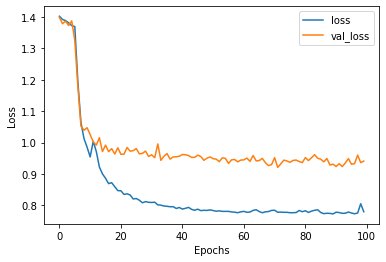

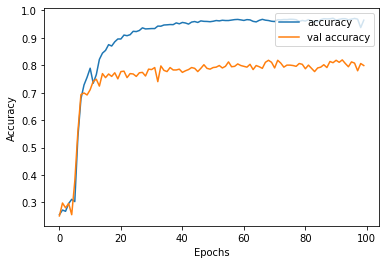

In [18]:
plot_learning_curve(history)

In [19]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(my_prediction)]


In [20]:
# I am feeling scared
prediction(model,tokenizer,"मुझे डर लग रहा है")

'fear'


In [21]:
# I like bass
prediction(model,tokenizer,"J'aime la basse")

'joy'


In [23]:
#I am going to fail 我会失败
prediction(model,tokenizer,"我会失败")

'sadness'


In [24]:
# My mother was killed
prediction(model,tokenizer,"मेरी मां को मार दिया गया")

'sadness'
